<a href="https://colab.research.google.com/github/manjitullal/DE-GAN/blob/main/DE_GAN_watermark_wgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DE GAN

https://arxiv.org/abs/2010.08764

https://arxiv.org/abs/1406.2661

In [3]:
!pip install tensorboardX

     |████████████████████████████████| 122kB 4.3MB/s 


In [2]:
!wget https://raw.githubusercontent.com/diegoalejogm/gans/master/utils.py

--2021-04-24 23:33:19--  https://raw.githubusercontent.com/diegoalejogm/gans/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4866 (4.8K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   4.75K  --.-KB/s    in 0s      

2021-04-24 23:33:20 (92.0 MB/s) - ‘utils.py’ saved [4866/4866]



In [1]:
# download the original grayscale images

!gdown --id 0B9eZ-svj9om8Yjc1YWYwZTUtYTNhOS00ZWE2LTliOGItM2UzMGM2M2VkNWRj
!unzip /content/the-iupr-dataset-of-camera-captured-documents-cbdar2011.zip

Downloading...
From: https://drive.google.com/uc?id=0B9eZ-svj9om8Yjc1YWYwZTUtYTNhOS00ZWE2LTliOGItM2UzMGM2M2VkNWRj
To: /content/the-iupr-dataset-of-camera-captured-documents-cbdar2011.zip
390MB [00:06, 58.3MB/s]
Archive:  /content/the-iupr-dataset-of-camera-captured-documents-cbdar2011.zip
   creating: the-iupr-dataset-of-camera-captured-documents-cbdar2011/
   creating: the-iupr-dataset-of-camera-captured-documents-cbdar2011/the-iupr-dataset-ground-truth-ocr-text/
  inflating: the-iupr-dataset-of-camera-captured-documents-cbdar2011/the-iupr-dataset-ground-truth-ocr-text/080_OCR_ASCII_TEXT_GT.txt  
  inflating: the-iupr-dataset-of-camera-captured-documents-cbdar2011/the-iupr-dataset-ground-truth-ocr-text/092_OCR_ASCII_TEXT_GT.txt  
  inflating: the-iupr-dataset-of-camera-captured-documents-cbdar2011/the-iupr-dataset-ground-truth-ocr-text/067_OCR_ASCII_TEXT_GT.txt  
  inflating: the-iupr-dataset-of-camera-captured-documents-cbdar2011/the-iupr-dataset-ground-truth-ocr-text/098_OCR_ASCII_T

## import

In [4]:
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import numpy as np
from PIL import ImageFont, ImageDraw, ImageOps
from random import randint
import matplotlib.font_manager as fm
import pandas as pd
from IPython import display
from utils import Logger

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchsummary import summary

In [5]:
from google.colab import drive
drive.mount('/content/drive') 

path = '/content/drive/MyDrive/Projects/CS7150/final/'

Mounted at /content/drive


## Create Watermarks

In [6]:
if not os.path.exists('watermarked_images'):
      os.makedirs('watermarked_images')
    
if not os.path.exists('clean_images'):
      os.makedirs('clean_images')
    
DATA_FOLDER = '/content/the-iupr-dataset-of-camera-captured-documents-cbdar2011/the-iupr-dataset-ground-truth-dewarped-scanned-documents/grayscale'

names = ['CLASSIFIED', 'TOP SECRET', 'DO NOT COPY', 'VERIFIED','CONFIDENTIAL', 'RIGHTS RESERVED', 'PYTHON', 'WATERMARKING', 'COMPANY', 'DRAFT']

def watermarking1(source,i,names = names):
    
    im=(Image.open(source))#*255
    cim=im.convert("L")
    cim = cim.resize((768,1024), Image.ANTIALIAS)
    cim.save('clean_images/'+str(i)+'.png')
    im=im.convert('RGB')
    f = fnt = ImageFont.truetype( fm.findfont(fm.FontProperties('Arial')), randint(250, 350))
    txt=Image.new('L', (randint(1500, 2000),randint(2000, 3000)))
    d = ImageDraw.Draw(txt)
    ran=randint(0, 9)
    d.text( (randint(20,260), randint(50,320)), names[ran],  font=f, fill=randint(245,253))
    w=txt.rotate(randint(0, 90),  expand=1)
    im.paste( ImageOps.colorize(w, (randint(0, 255),randint(0, 255),randint(0, 255)), (randint(0, 255),randint(0, 255),randint(0, 255))), (30,40),  w)
    im=im.convert('L')
    im = im.resize((768,1024), Image.ANTIALIAS)
    im.save('watermarked_images/'+str(i)+'w.png')

def watermarking2(source,ind, names2 = names):
    img = Image.open(source)
    cim=img.convert("L")
    cim = cim.resize((768,1024), Image.ANTIALIAS)
    cim.save('clean_images/'+str(ind)+'.jpg')
    img=img.convert('RGB')
    txt=Image.new('L', (randint(1500, 2200),randint(1500, 22000)))
    draw = ImageDraw.Draw(txt)
    fontSize=randint(250,310)
    font = ImageFont.truetype( fm.findfont(fm.FontProperties('Arial')), fontSize)
    x, y = (30, 200)
    # x, y = 10, 10
    col=(randint(0, 255),randint(0, 255),randint(0, 255))
    opacit=randint(245, 253)
    text = names2[randint(0,9)]
    w, h = font.getsize(text)
    draw.text((x, y), text,  font=font,  fill=opacit)
    cor = (x,y, x+w,y+h)
    width = fontSize//10
    for i in range(width):
        draw.rectangle(cor, fill= None, outline=opacit)   
        cor = (cor[0]-1,cor[1]+1, cor[2]+1,cor[3]+1) 
    w=txt.rotate(randint(0, 70),  expand=1)   
    img.paste( ImageOps.colorize(w, (randint(0, 255),randint(0, 255),randint(0, 255)), (randint(0, 255),randint(0, 255),randint(0, 255))), (0,600),  w)
    img=img.convert('L')
    img = img.resize((768,1024), Image.ANTIALIAS)
    img.save('watermarked_images/'+str(ind)+'w.jpg')

In [7]:
# find all the watermark files in the downloaded folder 
# create a dataframe

all_files = os.listdir(DATA_FOLDER)
all_files.sort()
all_files_path = [os.path.join(DATA_FOLDER, filename) for filename in all_files]
all_files_df = pd.DataFrame({'path': all_files_path, 'file_name': all_files})
all_files_df.head()

,path,file_name
0,/content/the-iupr-dataset-of-camera-captured-d...,001_SCANNED_GRAY_GT.jpg
1,/content/the-iupr-dataset-of-camera-captured-d...,002_SCANNED_GRAY_GT.jpg
2,/content/the-iupr-dataset-of-camera-captured-d...,003_SCANNED_GRAY_GT.jpg
3,/content/the-iupr-dataset-of-camera-captured-d...,004_SCANNED_GRAY_GT.jpg
4,/content/the-iupr-dataset-of-camera-captured-d...,005_SCANNED_GRAY_GT.jpg


In [8]:
# use method 2 to create watermarked images

%%time

for index, row in all_files_df.iterrows():    
  name = row.file_name.replace('.jpg', '')
  watermarking2(row.path, name) 

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


CPU times: user 57.7 s, sys: 6.36 s, total: 1min 4s
Wall time: 1min 3s


## sample images

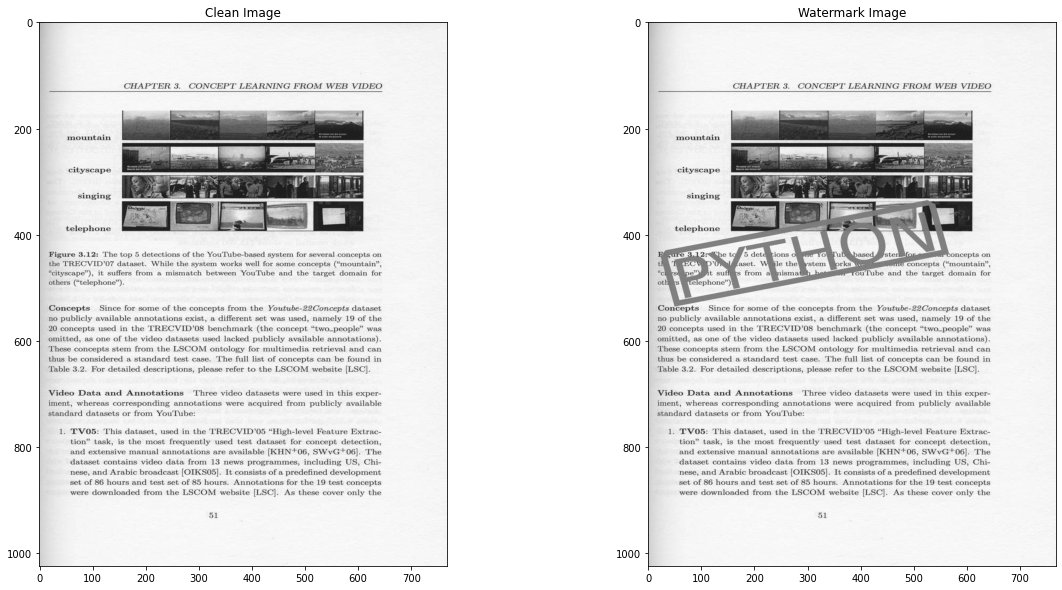

In [9]:
clean_image_path = '/content/clean_images/'
watermark_image_path = '/content/watermarked_images/'

random_number = np.random.randint(0,100)
image = all_files[random_number].split('.')[0]

clean_image = np.asarray(Image.open(clean_image_path + image + '.jpg'))
watermark_image = np.asarray(Image.open(watermark_image_path + image + 'w.jpg'))

print()
_, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(clean_image, cmap='gray')
ax[0].title.set_text('Clean Image')

ax[1].imshow(watermark_image, cmap='gray')
ax[1].title.set_text('Watermark Image')
plt.show()

In [10]:
print(clean_image.shape, watermark_image.shape)

(1024, 768) (1024, 768)


## create patches

original dataset is quite small with only 100 images. to create a bigger dataset create patches of images from the original dataset.

In [12]:
def getPatches(watermarked_image,clean_image,mystride):
    watermarked_patches=[]
    clean_patches=[]
        
    h =  ((watermarked_image.shape [0] // 256) +1)*256 
    w =  ((watermarked_image.shape [1] // 256 ) +1)*256
    image_padding=np.ones((h,w))
    image_padding[:watermarked_image.shape[0],:watermarked_image.shape[1]]=watermarked_image
    
    for j in range (0,h-256,mystride):  #128 not 64
        for k in range (0,w-256,mystride):
            watermarked_patches.append(image_padding[j:j+256,k:k+256])
    
    h =  ((clean_image.shape [0] // 256) +1)*256 
    w =  ((clean_image.shape [1] // 256 ) +1)*256

    image_padding=np.ones((h,w))
    image_padding[:clean_image.shape[0],:clean_image.shape[1]]=clean_image

    for j in range (0,h-256,mystride):    #128 not 64
        for k in range (0,w-256,mystride):
            clean_patches.append(image_padding[j:j+256,k:k+256])  
            
    return np.array(watermarked_patches),np.array(clean_patches)

In [13]:
%%time
_watermarked_patches , _cleanimage_patches = getPatches(watermark_image, clean_image, mystride=128+64)
print(_watermarked_patches.shape, _cleanimage_patches.shape)

(24, 256, 256) (24, 256, 256)
CPU times: user 13.1 ms, sys: 133 µs, total: 13.3 ms
Wall time: 12.4 ms


In [14]:
def create_patches():
  watermark_patches = []
  clean_patches = []

  for file in all_files:
    clean_image = np.asarray(Image.open(clean_image_path + file))
    watermark_image = watermark_image_path + file
    watermark_image = np.asarray(Image.open(watermark_image.replace('.jpg', 'w.jpg')))

    _watermark_patches , _clean_patches = getPatches(watermark_image, clean_image, mystride=128+64)
    watermark_patches.append(_watermark_patches)    
    clean_patches.append(_clean_patches)

  watermark_patches = np.concatenate(watermark_patches, axis=0)
  clean_patches = np.concatenate(clean_patches, axis=0)

  return watermark_patches, clean_patches

In [15]:
%%time

watermark_patches, clean_patches = create_patches()

CPU times: user 2.08 s, sys: 815 ms, total: 2.9 s
Wall time: 2.89 s


In [16]:
print(watermark_patches.shape, clean_patches.shape)

(2400, 256, 256) (2400, 256, 256)


## create dataset

In [17]:
class watermark(Dataset):

  def __init__(self, watermark_patches, clean_patches, transform=None):
    self.clean_patches = clean_patches
    self.watermark_patches = watermark_patches
    self.transform = transform

  def __len__(self):
    return len(self.clean_patches)

  def __getitem__(self, idx):
    clean_image = self.clean_patches[idx]
    watermark_image = self.watermark_patches[idx]

    clean_image = np.asarray(clean_image)
    watermark_image = np.asarray(watermark_image)

    clean_image = Image.fromarray(clean_image.astype(np.uint8))
    watermark_image = Image.fromarray(watermark_image.astype(np.uint8))

    if self.transform:
       clean_image = self.transform(clean_image)
       watermark_image = self.transform(watermark_image)

    return watermark_image, clean_image

dataset = watermark(watermark_patches, clean_patches, transform=transforms.Compose(
            [transforms.ToTensor(), 
             transforms.Normalize([0.5], [0.5])]))

bs = 16
data_loader = DataLoader(dataset, batch_size=bs, shuffle=True)
num_batches = len(data_loader)

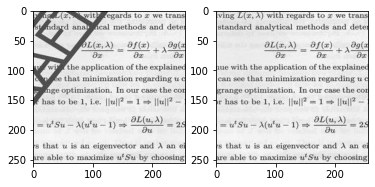

In [22]:
x,y = next(iter(data_loader))
_, ax = plt.subplots(1,2)
ax[0].imshow(x[0].squeeze(), cmap='gray')
ax[1].imshow(y[0].squeeze(), cmap='gray')
plt.show()

In [23]:
print(x.shape, y.shape)

torch.Size([16, 1, 256, 256]) torch.Size([16, 1, 256, 256])


## generator

In [24]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class GeneratorNet(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(GeneratorNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)
    
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 256, 256)

In [ ]:
# summary(generator, (1,256,256))

## discriminator

In [25]:
class DiscriminatorNet(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.disc = nn.Sequential(            
            nn.Conv2d(in_channels, 64, 3, 1, 1), # layer 1 64x256x256
            nn.LeakyReLU(0.2, inplace=True),                     
            nn.MaxPool2d(2),                     # layer 2 64x128x128
            nn.Conv2d(64, 128, 3, 1, 1),         # layer 3 128x128x128
            nn.LeakyReLU(0.2, inplace=True), 
            nn.MaxPool2d(2),                     # layer 4 128x64x64
            nn.Conv2d(128, 256, 3, 1, 1),        # layer 5 256x64x64
            nn.LeakyReLU(0.2, inplace=True),    # batch norm next
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),                     # layer 6 256x32x32
            nn.Conv2d(256, 256, 3, 1, 1),        # layer 7 256x32x32
            nn.LeakyReLU(0.2, inplace=True),    # batch norm next
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),                     # layer 8 256x16x16
            nn.Conv2d(256, 256, 3, 1, 1),        # layer 9 256x16x16
            nn.LeakyReLU(0.2, inplace=True),    # batch norm next
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 1, 3, 1, 1),          # layer 10 1x16x16
        )

    def forward(self, x,y):
        input = torch.cat([x,y], axis=1)
        return self.disc(input)
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [ ]:
# test_d = DiscriminatorNet(in_channels=2)
# x = torch.randn((16,1,256,256))
# out = test_d.forward(x,y)

In [26]:
discriminator = DiscriminatorNet(in_channels=2)
generator = GeneratorNet(in_channels=1, out_channels=1)

discriminator.cuda()
generator.cuda()

GeneratorNet(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(

## loss function

In [28]:
# Optimizers
d_optimizer = optim.RMSprop(discriminator.parameters(), lr=0.00005)
g_optimizer = optim.RMSprop(generator.parameters(), lr=0.00005)

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 100

## train and validate

In [29]:
def test_noise():
  x,y = next(iter(data_loader))
  return Variable(x).float().cuda()

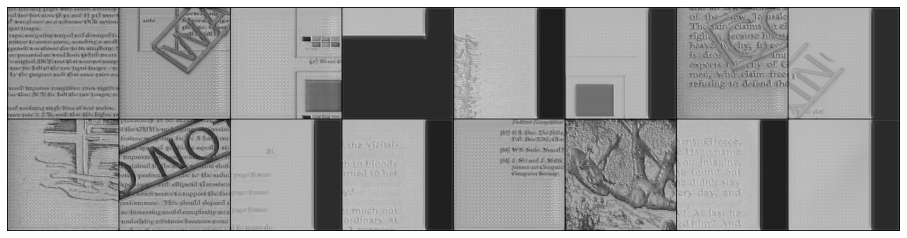

Epoch: [1/100], Batch Num: [100/150]
Discriminator Loss: 0.0000, Generator Loss: 0.0098
D(x): -0.0098, D(G(z)): -0.0098


In [ ]:
logger = Logger(model_name='DE-GAN', data_name='watermark')
num_test_samples = bs

for epoch in range(num_epochs):
    for n_batch, (watermark_batch, clean_batch) in enumerate(data_loader):

        real_data = clean_batch.float().cuda()
        noised_data = watermark_batch.float().cuda()
        
        # 1. Train Discriminator
        # Generate fake data
        fake_data = generator(noised_data).detach()

        # Reset gradients
        d_optimizer.zero_grad()
        
        # 1.1 Train on Real Data
        prediction_real = discriminator(real_data, noised_data)

        # Calculate error and backpropagate
        
        loss_real = -torch.mean(prediction_real)

        # 1.2 Train on Fake Data, you would need to add one more component
        prediction_fake = discriminator(fake_data, noised_data)

        # Calculate error and backpropagate
        
        loss_fake = torch.mean(prediction_fake)

        loss_d = loss_real + loss_fake
        loss_d.backward()
        
        # 1.3 Update weights with gradients
        d_optimizer.step()

        # Clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)
  
        # 2. Train Generator
        if n_batch % 5 == 0:
          g_optimizer.zero_grad()

          # generate data 
          gen_data = generator(noised_data)

          # Sample noise and generate fake data
          prediction = discriminator(gen_data, real_data)
        
          # Calculate error and backpropagate
          loss_g1 = -torch.mean(prediction)
          loss_g = loss_g1

          loss_g.backward()

          # Update weights with gradients
          g_optimizer.step()
                
          # Log error
          logger.log(loss_d, loss_g, epoch, n_batch, num_batches)

          # Display Progress
          if (n_batch) % 100 == 0:
              display.clear_output(True)
              # Display Images
              test_images = vectors_to_images(generator(test_noise())).data.cpu()
              logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
              # Display status Logs
              logger.display_status(
                  epoch, num_epochs, n_batch, num_batches,
                  loss_d, loss_g, prediction_real, prediction_fake
              )
          # Model Checkpoints
          logger.save_models(generator, discriminator, epoch)

## save model

In [ ]:
# v1 is 
# v2 is 200 epochs 

torch.save(generator.state_dict(), path + 'generator-watermark-final-wgan_v1.pt')
torch.save(discriminator.state_dict(), path + 'discriminator-watermark-final-wgan_v1.pt')

## inference 

In [ ]:
model = GeneratorNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load(path + 'generator-watermark-final-wgan_v1.pt'))
model.cuda()
model.eval()

GeneratorNet(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(

In [ ]:
def calculate_psnr(img1, img2, max_value=255):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))


PSNR between Clean Image and Predicted Image:  51.50975541841272



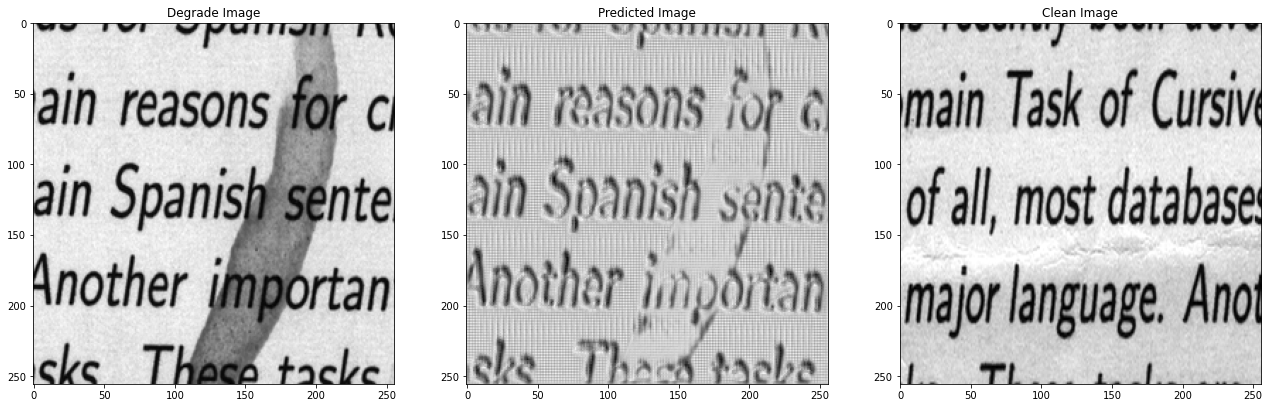

In [ ]:
degrade_image, clean_image = next(iter(data_loader))
output = model(degrade_image.cuda().float())

psnr = calculate_psnr(clean_image[0].detach().cpu(), output[0].detach().cpu())
print()
print('PSNR between Clean Image and Predicted Image: ', psnr)
print()
_, ax = plt.subplots(1,3, figsize=(22,10))
ax[0].imshow(degrade_image[0].squeeze(), cmap='gray')
ax[0].title.set_text('Degrade Image')
ax[1].imshow(output[0].detach().cpu().squeeze(), cmap='gray')
ax[1].title.set_text('Predicted Image')
ax[2].imshow(clean_image[0].detach().cpu().squeeze(), cmap='gray')
ax[2].title.set_text('Clean Image')
plt.show()

## Comparison with Paper


PSNR between Clean Image and Predicted Image:  52.435574260690096



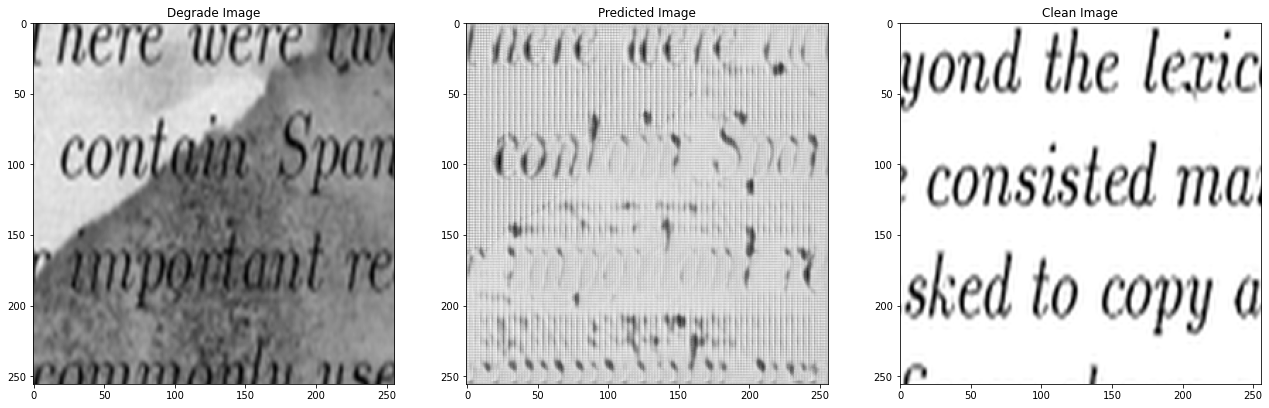

In [ ]:
path = '/content/drive/MyDrive/Projects/CS7150/original/'

clean_image = Image.open(path + '1cleaned.png')
clean_image = np.asarray(image_resize(clean_image))
clean_image = Image.fromarray(clean_image.astype(np.uint8))
clean_image = transforms.Compose([transforms.ToTensor(), 
                                     transforms.RandomCrop(256), 
                                     transforms.Resize(256), 
                                     transforms.Normalize([0.5], [0.5])])(clean_image)

degraded_image = Image.open(path + '1.png')
degraded_image = np.asarray(image_resize(degraded_image))
degraded_image = Image.fromarray(degraded_image.astype(np.uint8))
degraded_image = transforms.Compose([transforms.ToTensor(), 
                                     transforms.RandomCrop(256), 
                                     transforms.Resize(256), 
                                     transforms.Normalize([0.5], [0.5])])(degraded_image)
degraded_image = degraded_image.unsqueeze(0)

output = model(degraded_image.cuda().float())

psnr = calculate_psnr(clean_image[0].detach().cpu(), output[0].detach().cpu())
print()
print('PSNR between Clean Image and Predicted Image: ', psnr)
print()

_, ax = plt.subplots(1,3, figsize=(22,10))
ax[0].imshow(degraded_image[0].squeeze(), cmap='gray')
ax[0].title.set_text('Degrade Image')
ax[1].imshow(output[0].detach().cpu().squeeze(), cmap='gray')
ax[1].title.set_text('Predicted Image')
ax[2].imshow(clean_image[0].detach().cpu().squeeze(), cmap='gray')
ax[2].title.set_text('Clean Image')
plt.show()

In [ ]:
# Structural similarity score 

from skimage.metrics import structural_similarity as ssim

x = clean_image[0].detach().cpu().squeeze().numpy()
y = output[0].detach().cpu().squeeze().numpy()

ssim(x, y, data_range=x.max() - x.min())

0.5666986998895558

# Takeaways 

1. CV and PIL show the images differently, PIL image looks sharper than CV

# References 

https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f

https://github.com/diegoalejogm/gans